# Projet 5: Le gradient Proximal

## Préliminaires

### Importation des packages

In [1]:
from math import *
import random
import numpy as np
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

import pandas as pd  #pandas pour la gestion des données 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
# SciPy - Efficient mathematical calculation
from scipy.linalg.special_matrices import toeplitz # A special kind of matrices
from scipy.linalg import svdvals # Singular values
from scipy.linalg import norm # Euclidean norm


### Génération de la base de données

J'ai décidé de travailler sur un dataset que j'ai généré aléatoirement composé de 6 variables avec un coefficient de corrélation de 0.3. 
Connaissant les coefficients de régression, il est aussi plus simple de s'assurer du bon fonctionnement de la méthode et de l'implémentation de l'algorithme de descente de gradient.

In [ ]:
# Data generation.
# Code C. Royer lab session 1 et 2

def simu_linmodel(x, n, std=3., corr=0.3):
    """
    Simulation values obtained by a linear model with additive noise
    
    Parametres
    ----------
    x : np.ndarray, shape=(d,)
        Les coefficients du modèle 
    
    n : int
        Nombre d'observations
    
    std : float, default=1.
        écart-type du bruit

    corr : float, default=0.3
        Correlation de la matrice de design
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)*2
    noise = std * randn(n)
    y = A.dot(x) + noise
    return A, y

In [ ]:
# On génére 1000 données composées de 6 variables
np.random.seed(2)
n=1000
coef=np.array([6,4,0.8,0.02,7,3.8])
X,y=simu_linmodel(coef,n)
design=pd.DataFrame(X,columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])

In [ ]:
dataset=design
dataset

,X1,X2,X3,X4,X5,X6
0,5.274399,-1.812856,-1.122738,-0.049119,1.047518,2.030487
1,-2.364554,0.758303,-3.575054,-0.007266,-0.191838,3.260172
2,-2.663749,-0.477963,-0.630928,1.471575,-0.007127,1.473039
3,1.487323,0.808606,1.020364,-0.803193,1.857024,1.147829
4,0.528409,-0.401583,1.328396,-0.408052,-0.893387,3.012375
...,...,...,...,...,...,...
995,-0.734042,1.666495,0.523343,-1.469085,-0.901836,0.079112
996,-1.743097,-0.633492,-0.679026,-1.773226,0.651580,5.183884
997,-1.381542,-1.712876,2.307424,-0.351998,1.569736,0.151036
998,2.588537,3.378348,2.615572,-1.266597,-0.749053,0.095751


Nous obtenons la matrice de corrélation suivante.

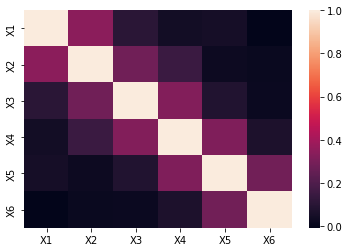

In [ ]:

#Matrice de corrélation
corrMatrix = dataset.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

### Séparation du training et du test set

In [ ]:
#Séparation du training set et du test set
X_train,X_test,y_train,y_test=train_test_split(design,y,test_size=0.33, random_state=1)



### Détermination de la borne supérieure pour le learningrate

In [ ]:
#Plus grand valeur propre de la matrice de XX.T
max_ev=max(np.linalg.eigvals(np.dot(X_train, X_train.T))).real
# Nous obtenons la borne supérieur du pas que nous pouvons utilisant grace au résulat théorique suivant 
step=1/max_ev
step

0.0002124782842013496

### Définition de la fonction de perte ridge 

In [ ]:
# Définition de la fonction de perte
def ridge_error(y,X,beta,lambd):

  return(((np.dot(X,beta)-y)**2).sum()/2+lambd*(beta**2).sum()/2)/len(y)

## Question 1: 
Add an l2 regularization term to your objective function from Part 1 or Part 3. Compare the solution of the unregularized problem to those obtained while solving the problem with:
 a) a small value for the regularization parameter 
 b) a large value for the regularization parameter

Dans cette partie nous cherchons à résoudre le problème suivant à l'aide de l'algorithme du gradient proximal:

$$\underset{β}{minimiser} \frac{1}{2n}\lVert X β-Y \rVert_{2}^2+\frac{λ}{2} \lVertβ \rVert_{2}^2$$

.

In [ ]:
batch_size=1
def gradient_stochastique_descent_prox_l2(X, y,lambd, learningrate=1e-2, epochs=1000000,epsilon=1e-5, batch_size=batch_size,arret=True, monit=True):
  """
  Algorithme de descent de gradient avec pénalité ridge
  
  Parametres
  ----------
  X : np.array
    matrice de design

  y : np.array
    vecteur du target

  lambd: float
    parametre de régularisation

  epochs: int
    Nombre d'epochs


  monit : bool
      Affiche l'itération en cours


  
  arret : bool
      Algorithme s'arrete lorsque la condition d'arret est satisfaite
  

  epsilon : float
      Paramètre de précision pour la condition d'arret
  """  
  n=np.shape(X)[0]
  X=np.array(X)
  beta = np.array([0,0,0,0,0,0]).reshape(-1,1) # Initialisation des coefficients
  for i in range(epochs+1):
    if i%(epochs/10)==0 and monit:
      print("itération {} en cours ...".format(i))
    # Updating beta
    ind=np.random.randint(0,n-1,batch_size) # On choisit les indices sur lesquels on effectue la descente de gradient aléatoirement
    X_ind=np.array([X[i] for i  in ind ])
    y_ind=np.array([y[i] for i  in ind ]).reshape(-1,1)
    delta =  np.dot(X_ind,beta)-y_ind
    gradient=np.dot(X_ind.T,delta) # On calcule le gradient
    pas= learningrate/(1+lambd*learningrate)
    beta_new= beta-pas * gradient # on retire un gradient
    
    if arret and np.linalg.norm(gradient)<epsilon: #Condition d'arrêt
      print("L'algorithme a convergé ")
      break
    beta=beta_new
    
  return beta

def gradient_descent_prox_l2(X, y,lambd, learningrate=1e-3, epochs=10000,epsilon=1e-5,arret=True, monit=True):
  """
  Algorithme de descent de gradient avec pénalité ridge
  
  Parametres
  ----------
  X : np.array
    matrice de design

  y : np.array
    vecteur du target

  lambd: float
    parametre de régularisation

  epochs: int
    Nombre d'epochs


  monit : bool
      Affiche l'itération en cours

  
  arret : bool
      Algorithme s'arrete lorsque la condition d'arret est satisfaite
  

  epsilon : float
      Paramètre de précision pour la condition d'arret
  """  
  beta = np.array([0,0,0,0,0,0]).reshape(-1,1) # Initialisation des coefficients
  for i in range(epochs+1):
    if monit and i%(epochs/10)==0: #monitoring
      print("itération {} en cours ...".format(i))
    # Updating beta
    delta =  np.subtract(np.dot(X,beta),y.reshape(-1,1))
    gradient=np.dot(X.T,delta)
    pas= learningrate/(1+lambd*learningrate)
    beta_new= beta-pas * gradient # on retire un gradient

    if arret and np.linalg.norm((np.array(beta)-np.array(beta_new)))<epsilon: #condition d'arrêt
      print("L'algorithme a convergé ")
      break
    beta=beta_new
    
  return beta


Nous allons comparer à l'aide d'un tableau les solutions des différents problèmes avec les vrais coefficients de regression. Nous allons également comparer les résultats entre eux.

In [ ]:
# On initialise le tableau des résultats
resultats = pd.DataFrame(columns = ['X1', 
                                 'X2','X3','X4','X5','X6'], 
                      index = ['Coefficients réels',
                               'GD unregularized', 
                               'SGD unregularized', 
                               'GD small regularization', 
                               'SGD small regularization',
                               'GD large regularization', 
                               'SGD large regularization',])
resultats.loc['Coefficients réels']= np.ravel(coef)

Pour la petite valeur de régularisation nous choisissons $λ=10$

Pour la grande valeur de régularisation nous choisissons  $λ=10^9$

In [ ]:
resultats.loc['GD unregularized'] =np.ravel(gradient_descent_prox_l2(X_train,y_train,lambd=0,learningrate=step, monit=False))
resultats.loc['GD small regularization'] =np.ravel(gradient_descent_prox_l2(X_train,y_train,lambd=10,learningrate=step, monit=False))
resultats.loc['GD large regularization'] =np.ravel(gradient_descent_prox_l2(X_train,y_train,lambd=1e9,learningrate=step, monit=False))
resultats.loc['SGD unregularized'] =np.ravel(gradient_stochastique_descent_prox_l2(X_train,y_train,lambd=0, batch_size=1,learningrate=step, monit=False))
resultats.loc['SGD small regularization'] =np.ravel(gradient_stochastique_descent_prox_l2(X_train,y_train,lambd=2, batch_size=1,learningrate=step, monit=False))
resultats.loc['SGD large regularization'] =np.ravel(gradient_stochastique_descent_prox_l2(X_train,y_train,lambd=1e9, batch_size=1,learningrate=step, monit=False))

L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 


In [ ]:
resultats

,X1,X2,X3,X4,X5,X6
Coefficients réels,6.0,4.0,0.8,0.02,7.0,3.8
GD unregularized,6.035348,3.988605,0.693973,-0.003638,6.958999,3.910213
SGD unregularized,6.050385,3.995194,0.688877,-0.043551,6.970376,3.950053
GD small regularization,6.035348,3.988605,0.693973,-0.003638,6.958998,3.910213
SGD small regularization,6.024083,3.974387,0.684549,-0.042604,7.025692,3.933603
GD large regularization,0.219309,0.189297,0.068891,0.083426,0.235597,0.158228
SGD large regularization,0.033334,0.028726,0.010529,0.012809,0.035847,0.024029


Grâce au tableau des résultats ci-dessus, nous pouvons faire les remarques suivantes:

- Avec la constante de régularisation large les algorithmes ne convergent pas vers la solution, les coefficients sont plus petits et s'approchent de zéro.
- Il n'y a pas de différence significative entre les résulats des algos sans régularisation et avec une faible régularisation pour ce problème.


## Question 2: 
Add a l-1 regularization term to your objective function from Part 1 or Part 3 and solve the resulting problem. Can you find a value of the regularization parameter that yields a sparse solution? Does it provide a good value for the data-fitting term?

Dans cette partie nous cherchons à résoudre le problème suivant à l'aide de l'algorithme du gradient proximal:

$$\underset{β}{minimiser} \frac{1}{2n}\lVert X β-Y \rVert_{2}^2+\frac{λ}{2} \lVertβ \rVert_{1}$$



In [ ]:
#soft-thresholding function 
def soft_thresholding(t,mu):
  if t <= -mu :
    return t+mu
  if  t >= mu:
    return t-mu
  else:
    return 0.0
  
def gradient_stochastique_descent_prox_lasso(X, y,lambd, learningrate=1e-3, epochs=10000,epsilon=1e-2, batch_size=batch_size,arret=True, monit=True):
    
    n=np.shape(X)[0]
    X=np.array(X)
    beta = np.array([0,0,0,0,0,0]).reshape(-1,1) # Initialisation des coefficients
    for i in range(epochs+1):
      if monit and  i%(epochs/10)==0:
        print("itération {} en cours ...".format(i))
      # Updating beta
      ind=np.random.randint(0,n-1,batch_size) # On choisit les indices sur lesquels on effectue la descente de gradient aléatoirement
      X_ind=np.array([X[i] for i  in ind ])
      y_ind=np.array([y[i] for i  in ind ]).reshape(-1,1)
      delta =  np.subtract(np.dot(X_ind,beta.reshape(-1,1)),y_ind)
      gradient=np.dot(X_ind.T,delta)  # On calcule le gradient
      t=np.subtract(beta,learningrate*gradient).ravel()
      
      beta_new= [0,0,0,0,0,0]
      for j in range(len(gradient)):
        beta_new[j]=soft_thresholding(t[j],learningrate*lambd)

      if arret and  np.sum(gradient**2)<epsilon: #Condition d'arrêt
        print("L'algorithme a convergé ")
        break
      beta=np.array(beta_new).reshape(-1,1)
     
    return beta

def gradient_descent_prox_lasso(X, y,lambd, learningrate=1e-3, epochs=3000,epsilon=1e-5,arret=True, monit=True):
    beta = np.array([0,0,0,0,0,0]).reshape(-1,1) # Initialisation des coefficients
    for i in range(epochs+1):
      if monit and i%(epochs/10)==0: #monitoring
        print("itération {} en cours ...".format(i))
        
      # Updating beta
      delta =  np.subtract(np.dot(X,beta.reshape(-1,1)),y.reshape(-1,1))
      gradient=np.dot(X.T,delta) 
      t=np.subtract(beta ,learningrate*gradient)
      #print(beta)
      beta_new= np.array([0.0,0.0,0.0,0.0,0.0,0.0])
      for j in range(len(gradient)):
        beta_new[j]=soft_thresholding(t[j], learningrate*lambd)
        


      if arret and np.sum(gradient**2)<epsilon: #condition d'arrêt
        print("L'algorithme a convergé ")
        break
      beta=beta_new.reshape(-1,1)
      
     
    return beta


#### Pour la descente de gradient classique

On initialise un tableau avec les différentes valeurs de la constante de régularisation en lignes et les 6 coefficients à trouver en colonnes.

In [ ]:
regularizers=[45,1e2,1e4,1e6]   #np.ceil(np.linspace(1,1000,10))
resultats_lasso_GD = pd.DataFrame(columns = ['X1', 
                                 'X2','X3','X4','X5','X6'], 
                      index =regularizers)
resultats_lasso_GD.loc['Coefficients réels']= np.ravel(coef)

In [ ]:
# Gradient proximal pour descente de gradient 
for lambd in regularizers:
  print(lambd)
  resultats_lasso_GD.loc[lambd] =np.ravel(gradient_descent_prox_lasso(X_train,y_train, learningrate=step, epochs=3000,lambd=float(lambd),monit=False))


45
100.0
10000.0
1000000.0


In [ ]:
resultats_lasso_GD

,X1,X2,X3,X4,X5,X6
45.0,6.023354,3.981223,0.679686,0.00,6.947688,3.896714
100.0,6.008488,3.972481,0.663508,0.00,6.935255,3.879902
10000.0,3.468712,1.785167,0.000000,0.00,4.542243,0.879054
1000000.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
Coefficients réels,6.000000,4.000000,0.800000,0.02,7.000000,3.800000


On remarque qu'avec une valeur de λ (le paramètre de régularition) égale à $45$ ou encore 100, on obtient une solution avec un coefficient nul (X4). Avec $λ=10^4$ également (les coefficients pour X3 et X4 sont nuls).

On remarque aussi que plus la pénalité est grande, moins les coefficients obtenus sont proches des coefficients réels .
Lasso n'est pas efficace pour trouver la valeur des coefficients mais permet de trouver assez facilement les coefficients nuls ou très proches de zéro.

#### Pour le Gradient stochastique

On initialise un tableau avec les différentes valeurs de la constante de régularisation en lignes et les 6 coefficients à trouver en colonnes.

In [ ]:
regularizers_SGD=np.array(range(0,30,5))
resultats_lasso_SGD = pd.DataFrame(columns = ['X1', 
                                 'X2','X3','X4','X5','X6'], 
                      index =regularizers_SGD)
resultats_lasso_SGD.loc['Coefficients réels']= np.ravel(coef)

In [ ]:
# Gradient proximal pour descente de gradient stochastique
for lambd in regularizers_SGD: 
  resultats_lasso_SGD.loc[lambd] = np.ravel(gradient_stochastique_descent_prox_lasso(X_train,y_train,lambd=lambd, learningrate=step, epochs=30000, monit=False))

L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 
L'algorithme a convergé 


In [ ]:
resultats_lasso_SGD

,X1,X2,X3,X4,X5,X6
0,2.131280,1.746384,0.617407,0.464827,2.065778,1.266705
5,2.054975,1.553037,0.398605,0.432946,2.117425,1.401592
10,4.058033,2.527267,0.006315,0.007683,4.503922,2.104234
15,2.314293,1.611235,-0.020570,0.000000,2.605307,0.882349
20,0.097556,0.099435,0.040618,0.016501,0.125087,0.042109
25,1.491555,0.047507,0.010247,0.000000,2.005318,0.005455
Coefficients réels,6.000000,4.000000,0.800000,0.020000,7.000000,3.800000


Même constat que pour le gradient classique.